In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud,STOPWORDS
from bs4 import BeautifulSoup
import re,string,unicodedata
import os
from IPython.display import Image

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, RocCurveDisplay, PrecisionRecallDisplay, ConfusionMatrixDisplay
#from xgboost.sklearn import XGBClassifier

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Dense,Input, Embedding,LSTM,Dropout,Conv1D, MaxPooling1D, GlobalMaxPooling1D,Dropout,Bidirectional,Flatten,BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
#import transformers
#import tokenizers
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score
from sklearn.utils.class_weight import compute_class_weight

2024-06-09 07:34:30.175016: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-09 07:34:30.184501: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-09 07:34:30.608371: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-09 07:34:32.226716: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-09 07:34:34.773379: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF

In [2]:
#loading data
data = pd.read_excel('final_data1.xlsx')
data1= data.copy()

In [3]:
data.head()

,item,date,text,number,class,price
0,1.0,2022-10-03,DMG Blockchain Solutions goes live on the Boso...,24,Extreme Fear,19623.58008
1,2.0,2022-10-03,NYDIG Promotes Leaders Amidst Record Bitcoin B...,24,Extreme Fear,19623.58008
2,3.0,2022-10-03,Bitcoin Mining as Bad for Planet as Oil Drilli...,24,Extreme Fear,19623.58008
3,4.0,2022-10-03,Bitcoin climate impact greater than gold minin...,24,Extreme Fear,19623.58008
4,5.0,2022-10-03,Bitcoin Is â€˜Comforting' And â€˜Can't Be Stop...,24,Extreme Fear,19623.58008


In [4]:
#Fill missing values
data['text'] = data['text'].astype(str).fillna('')

In [5]:
#map the class to numerical value add column sentiment (numerical class) change the number of classes to 3 classes
mapping = {     
    'Extreme Fear': 0,
    'Fear': 0,
    'Neutral': 2,
    'Greed': 1,
    'Extreme Greed': 1
}
data['label'] = data['class'].map(mapping)

In [6]:
#remove Neutral class
data= data[data['label'] != 2]

In [7]:
data.head()

,item,date,text,number,class,price,label
0,1.0,2022-10-03,DMG Blockchain Solutions goes live on the Boso...,24,Extreme Fear,19623.58008,0
1,2.0,2022-10-03,NYDIG Promotes Leaders Amidst Record Bitcoin B...,24,Extreme Fear,19623.58008,0
2,3.0,2022-10-03,Bitcoin Mining as Bad for Planet as Oil Drilli...,24,Extreme Fear,19623.58008,0
3,4.0,2022-10-03,Bitcoin climate impact greater than gold minin...,24,Extreme Fear,19623.58008,0
4,5.0,2022-10-03,Bitcoin Is â€˜Comforting' And â€˜Can't Be Stop...,24,Extreme Fear,19623.58008,0


In [8]:
data.shape

(2360, 7)

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2360 entries, 0 to 2379
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   item    2281 non-null   float64       
 1   date    2359 non-null   datetime64[ns]
 2   text    2360 non-null   object        
 3   number  2360 non-null   int64         
 4   class   2360 non-null   object        
 5   price   2360 non-null   float64       
 6   label   2360 non-null   int64         
dtypes: datetime64[ns](1), float64(2), int64(2), object(2)
memory usage: 147.5+ KB


In [10]:
data.describe()

,item,date,number,price,label
count,2281.000000,2359,2360.000000,2360.000000,2360.000000
mean,1142.360807,2022-04-28 13:29:25.663416576,34.555508,27379.297608,0.207627
min,1.000000,2021-01-01 00:00:00,10.000000,19416.568360,0.000000
25%,571.000000,2021-06-01 12:00:00,23.000000,19623.580080,0.000000
50%,1141.000000,2022-10-04 00:00:00,24.000000,20160.716800,0.000000
75%,1711.000000,2022-10-06 00:00:00,26.000000,34616.066410,0.000000
max,2301.000000,2022-10-09 00:00:00,95.000000,63503.457030,1.000000
std,660.803311,NaN,22.612206,12986.845693,0.405694


In [11]:
data['label'].value_counts()

label
0    1870
1     490
Name: count, dtype: int64

<Figure size 800x600 with 0 Axes>

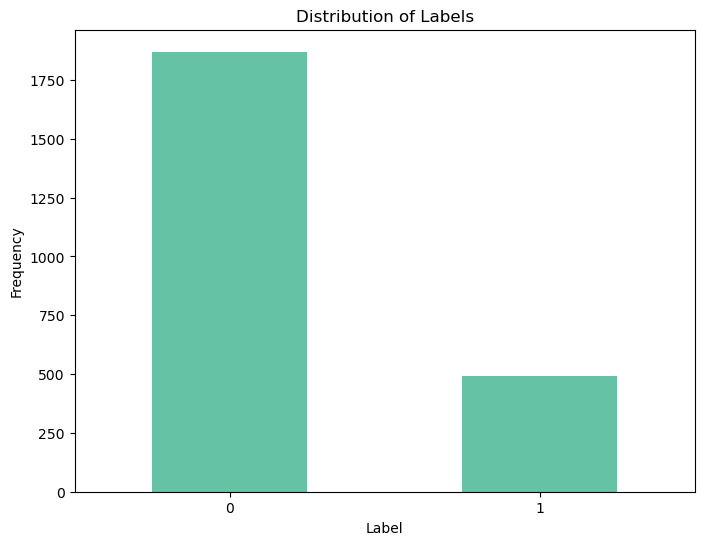

In [12]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
#colors = ['#fc8d62','#66c2a5']
# Mapping labels to categories


plt.figure(figsize=(8, 6))
data['label'].value_counts().plot(kind='bar', color=['#66c2a5'])

label_mapping = {0: 'Fear', 1: 'Greed'}
data['label'] = data['label'].map(label_mapping)
plt.title('Distribution of Labels')
plt.xlabel('Label')
plt.ylabel('Frequency')
plt.xticks(rotation=0)


# Saving the plot as a PNG file
plt.savefig('label_distribution.png')
plt.show()

In [13]:
label_mapping = {'Fear':0, 'Greed':1}
data['label'] = data['label'].map(label_mapping)

In [14]:
data.drop_duplicates(inplace = True)

In [15]:
data.shape

(2360, 7)

In [16]:
stop = stopwords.words('english')
wl = WordNetLemmatizer()

In [17]:
mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", 
           "'cause": "because", "could've": "could have", "couldn't": "could not", 
           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", 
           "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", 
           "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", 
           "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will", 
           "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", 
           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have",
           "i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", 
           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have",
           "it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", 
           "might've": "might have","mightn't": "might not","mightn't've": "might not have", 
           "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", 
           "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", 
           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", 
           "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", 
           "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", 
           "she's": "she is", "should've": "should have", "shouldn't": "should not", 
           "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is",
           "that'd": "that would", "that'd've": "that would have", "that's": "that is", 
           "there'd": "there would", "there'd've": "there would have", "there's": "there is", 
           "here's": "here is","they'd": "they would", "they'd've": "they would have", 
           "they'll": "they will", "they'll've": "they will have", "they're": "they are", 
           "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", 
           "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", 
           "we're": "we are", "we've": "we have", "weren't": "were not", 
           "what'll": "what will", "what'll've": "what will have","what're": "what are",  
           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", 
           "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", 
           "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", 
           "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", 
           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", 
           "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have",
           "y'all're": "you all are","y'all've": "you all have","you'd": "you would", 
           "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", 
           "you're": "you are", "you've": "you have" }

In [18]:

import nltk
nltk.download('wordnet')
def clean_text(text,lemmatize = True):
    soup = BeautifulSoup(text, "html.parser") #remove html tags
    text = soup.get_text()
    text = ' '.join([mapping[t] if t in mapping else t for t in text.split(" ")]) #expanding chatwords and contracts clearing contractions
    emoji_clean= re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    text = emoji_clean.sub(r'',text)
    text = re.sub(r'\.(?=\S)', '. ',text) #add space after full stop
    text = re.sub(r'http\S+', '', text) #remove urls
    text = "".join([word.lower() for word in text if word not in string.punctuation]) #remove punctuation
    #tokens = re.split('\W+', text) #create tokens
    if lemmatize:
        text = " ".join([wl.lemmatize(word) for word in text.split() if word not in stop and word.isalpha()]) #lemmatize
    else:
        text = " ".join([word for word in text.split() if word not in stop and word.isalpha()]) 
    return text

[nltk_data] Downloading package wordnet to /home/bitta693/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [19]:
data['text']=data['text'].apply(clean_text,lemmatize = True)

/tmp/ipykernel_147575/3037743114.py:4: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser") #remove html tags


In [20]:
#splitting into train and test
train, test= train_test_split(data, test_size=0.2, random_state=42)

#train dataset
Xtrain, ytrain = train['text'], train['label']

#test dataset
Xtest, ytest = test['text'], test['label']

print(Xtrain.shape,ytrain.shape)
print(Xtest.shape,ytest.shape)

(1888,) (1888,)
(472,) (472,)


In [21]:
import numpy as np
from sklearn.utils import class_weight
classes = np.unique(ytrain)
class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=classes,
    y=ytrain
)
class_weights_dict = dict(zip(classes, class_weights))
print("Class weights:", class_weights)

Class weights: [0.62891406 2.43927649]


In [22]:


pipe = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('classifier', LogisticRegression(solver='liblinear', class_weight=class_weights_dict))
])

# Train the model
pipe.fit(Xtrain, ytrain)

# Test the model
predictions = pipe.predict(Xtest)

# Evaluate the model
print("Accuracy:", accuracy_score(ytest, predictions))
print("Classification Report:")
print(classification_report(ytest, predictions))

Accuracy: 0.8728813559322034
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.94      0.92       369
           1       0.75      0.63      0.68       103

    accuracy                           0.87       472
   macro avg       0.82      0.79      0.80       472
weighted avg       0.87      0.87      0.87       472



Confusion Matrix:
[[347  22]
 [ 38  65]]


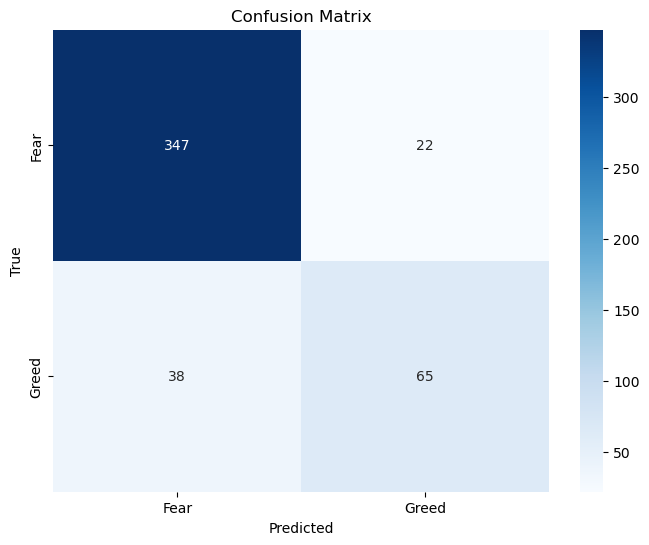

In [23]:

# Confusion Matrix
cm = confusion_matrix(ytest, predictions)


print("Confusion Matrix:")
print(cm)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
class_names = ['Fear', 'Greed']
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.savefig('logismatrix.png')
plt.show()

In [24]:
vect = TfidfVectorizer()
Xtrain_vect= vect.fit_transform(Xtrain)
Xtest_vect = vect.transform(Xtest)


count_vect = CountVectorizer() 
Xtrain_count = count_vect.fit_transform(Xtrain)
Xtest_count = count_vect.transform(Xtest)

In [25]:
MAX_VOCAB_SIZE = 10000
tokenizer = Tokenizer(num_words = MAX_VOCAB_SIZE,oov_token="<oov>")
tokenizer.fit_on_texts(Xtrain)
word_index = tokenizer.word_index
#print(word_index)
V = len(word_index)
print("Vocabulary of the dataset is : ",V)

Vocabulary of the dataset is :  4249


In [26]:
##create sequences of reviews
seq_train = tokenizer.texts_to_sequences(Xtrain)
seq_test =  tokenizer.texts_to_sequences(Xtest)

In [27]:
#choice of maximum length of sequences
seq_len_list = [len(i) for i in seq_train + seq_test]

#if we take the direct maximum then
max_len=max(seq_len_list)
print('Maximum length of sequence in the list: {}'.format(max_len))

Maximum length of sequence in the list: 25


In [28]:
# when setting the maximum length of sequence, variability around the average is used.
max_seq_len = np.mean(seq_len_list) + 2 * np.std(seq_len_list)
max_seq_len = int(max_seq_len)
print('Maximum length of the sequence when considering data only two standard deviations from average: {}'.format(max_seq_len))

Maximum length of the sequence when considering data only two standard deviations from average: 16


In [29]:
perc_covered = np.sum(np.array(seq_len_list) < max_seq_len) / len(seq_len_list)*100
print('The above calculated number coveres approximately {} % of data'.format(np.round(perc_covered,2)))

The above calculated number coveres approximately 92.33 % of data


In [30]:
#create padded sequences
pad_train=pad_sequences(seq_train,truncating = 'post', padding = 'pre',maxlen=max_seq_len)
pad_test=pad_sequences(seq_test,truncating = 'post', padding = 'pre',maxlen=max_seq_len)

In [31]:
def plotLearningCurve(history,epochs,name):
    
    epochRange = range(1,epochs+1)
    fig , ax = plt.subplots(1,2,figsize = (10,5))
  
    ax[0].plot(epochRange,history.history['accuracy'],label = 'Training Accuracy')
    ax[0].plot(epochRange,history.history['val_accuracy'],label = 'Validation Accuracy')
    ax[0].set_title('Training and Validation accuracy')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Accuracy')
    ax[0].legend()
    ax[1].plot(epochRange,history.history['loss'],label = 'Training Loss')
    ax[1].plot(epochRange,history.history['val_loss'],label = 'Validation Loss')
    ax[1].set_title('Training and Validation loss')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Loss')
    ax[1].legend()
    fig.tight_layout()
    plt.savefig(name)
    plt.show()

In [32]:
#Splitting training set for validation purposes
Xtrain,Xval,ytrain,yval=train_test_split(pad_train,ytrain,
                                             test_size=0.2,random_state=10)

In [33]:
from tensorflow.keras.layers import Input, Embedding, BatchNormalization, Dropout, Conv1D, MaxPooling1D, Bidirectional, LSTM, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

def lstm_model(Xtrain, Xval, ytrain, yval, V, D, maxlen, epochs):
    print("----Building the model----")
    i = Input(shape=(maxlen,))
    x = Embedding(V + 1, D)(i)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = Conv1D(32, 5, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = MaxPooling1D(2)(x)
    x = Bidirectional(LSTM(128, return_sequences=True))(x)
    x = LSTM(64)(x)
    x = Dropout(0.5)(x)
    x = Dense(1, activation='sigmoid')(x)
    model = Model(i, x)
    model.summary()


    ytrain = np.array(ytrain).reshape(-1, 1)
    yval = np.array(yval).reshape(-1, 1)
    

    classes, counts = np.unique(ytrain, return_counts=True)
    print(f"Classes: {classes}")
    print(f"Counts: {counts}")
    

    class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=ytrain.ravel())
    class_weights = dict(zip(classes, class_weights))
    print(f"Class weights: {class_weights}")


    print("----Training the network----")
    model.compile(optimizer=Adam(0.000007),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    r = model.fit(Xtrain, ytrain, 
                  validation_data=(Xval, yval), 
                  epochs=epochs, 
                  verbose=2,
                  batch_size=32,
                  class_weight=class_weights)
            
                  

    train_score = model.evaluate(Xtrain, ytrain, verbose=0)
    val_score = model.evaluate(Xval, yval, verbose=0)
    
    print(f"Train score: {train_score}")
    print(f"Validation score: {val_score}")
    
    n_epochs = len(r.history['loss'])
    
    return r, model, n_epochs


In [34]:
D = 64 #embedding dims
epochs = 140
r,model,n_epochs = lstm_model(Xtrain,Xval,ytrain,yval,V,D,max_seq_len,epochs)

----Building the model----


2024-06-09 07:34:39.962309: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:282] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 16, 64)         │       272,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 16, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 12, 32)         │        10,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 12, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 6, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 6, 256)         │       164,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        82,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 529,633 (2.02 MB)

 Trainable params: 529,505 (2.02 MB)

 Non-trainable params: 128 (512.00 B)

Classes: [0 1]
Counts: [1197  313]
Class weights: {0: 0.6307435254803676, 1: 2.412140575079872}
----Training the network----
Epoch 1/140
48/48 - 5s - 114ms/step - accuracy: 0.5669 - loss: 0.6860 - val_accuracy: 0.8280 - val_loss: 0.6915
Epoch 2/140
48/48 - 1s - 14ms/step - accuracy: 0.5868 - loss: 0.6767 - val_accuracy: 0.8228 - val_loss: 0.6907
Epoch 3/140
48/48 - 1s - 13ms/step - accuracy: 0.6285 - loss: 0.6645 - val_accuracy: 0.8016 - val_loss: 0.6896
Epoch 4/140
48/48 - 1s - 13ms/step - accuracy: 0.6470 - loss: 0.6524 - val_accuracy: 0.7778 - val_loss: 0.6881
Epoch 5/140
48/48 - 1s - 13ms/step - accuracy: 0.6788 - loss: 0.6437 - val_accuracy: 0.7804 - val_loss: 0.6855
Epoch 6/140
48/48 - 1s - 13ms/step - accuracy: 0.6987 - loss: 0.6307 - val_accuracy: 0.7566 - val_loss: 0.6827
Epoch 7/140
48/48 - 1s - 12ms/step - accuracy: 0.6967 - loss: 0.6224 - val_accuracy: 0.7540 - val_loss: 0.6774
Epoch 8/140
48/48 - 1s - 12ms/step - accuracy: 0.7179 - loss: 0.6117 - val_accuracy: 0.7513 - val

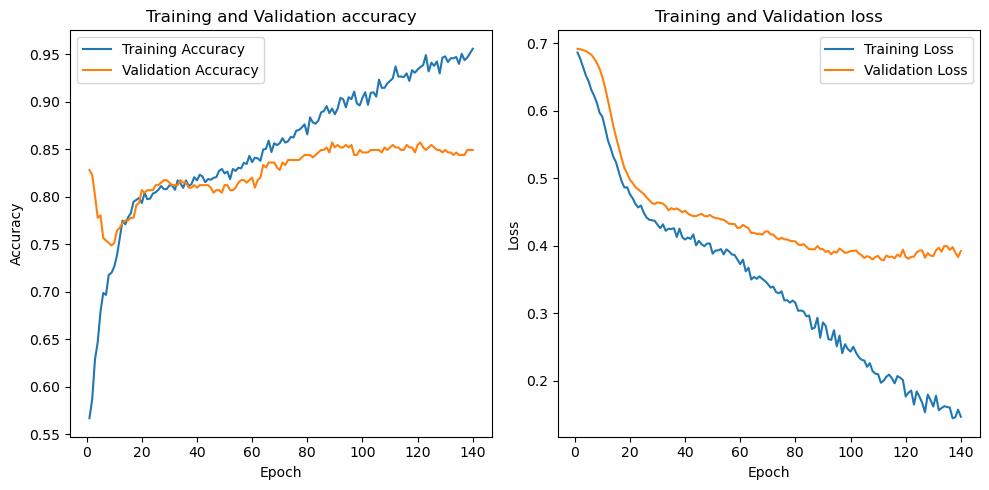

In [35]:
plotLearningCurve(r,n_epochs,'1')

In [36]:
print("Evaluate Model Performance on Test set")
result = model.evaluate(pad_test,ytest)
print(dict(zip(model.metrics_names, result)))

Evaluate Model Performance on Test set
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8902 - loss: 0.2720
{'loss': 0.2992241382598877, 'compile_metrics': 0.8771186470985413}


15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step


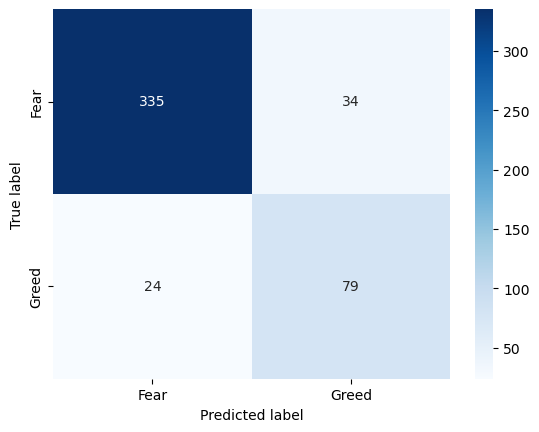

              precision    recall  f1-score   support

           0       0.93      0.91      0.92       369
           1       0.70      0.77      0.73       103

    accuracy                           0.88       472
   macro avg       0.82      0.84      0.83       472
weighted avg       0.88      0.88      0.88       472



In [37]:

ypred = model.predict(pad_test)
ypred = ypred>0.5
#Get the confusion matrix
cf_matrix = confusion_matrix(ytest, ypred)
class_names = ['Fear', 'Greed']
sns.heatmap(cf_matrix , annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.savefig('LSTMmat.png')
plt.show()
print(classification_report(ytest, ypred))

In [38]:
from tensorflow.keras.layers import Input, Embedding, BatchNormalization, Dropout, Conv1D, MaxPooling1D, Bidirectional, SimpleRNN, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

def rnn_model(Xtrain, Xval, ytrain, yval, V, D, maxlen, epochs):
    print("----Building the model----")
    i = Input(shape=(maxlen,))
    x = Embedding(V + 1, D)(i)  
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = Conv1D(32, 5, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = MaxPooling1D(2)(x)
    x = Bidirectional(SimpleRNN(128, return_sequences=True))(x)
    x = SimpleRNN(64)(x)
    x = Dropout(0.5)(x)
    x = Dense(1, activation='sigmoid')(x)
    model = Model(i, x)
    model.summary()
    ytrain = np.array(ytrain).reshape(-1, 1)
    yval = np.array(yval).reshape(-1, 1)
    classes, counts = np.unique(ytrain, return_counts=True)
    print(f"Classes: {classes}")
    print(f"Counts: {counts}")
    class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=ytrain.ravel())
    class_weights = dict(zip(classes, class_weights))
    print(f"Class weights: {class_weights}")

    # Training the LSTM
    print("----Training the network----")
    model.compile(optimizer=Adam(0.000007),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    r = model.fit(Xtrain, ytrain, 
                  validation_data=(Xval, yval), 
                  epochs=epochs, 
                  verbose=2,
                  batch_size=32,
                  class_weight=class_weights)
                  #callbacks = callbacks
                  
    # Evaluate the model
    train_score = model.evaluate(Xtrain, ytrain, verbose=0)
    val_score = model.evaluate(Xval, yval, verbose=0)
    
    print(f"Train score: {train_score}")
    print(f"Validation score: {val_score}")
    
    n_epochs = len(r.history['loss'])
    
    return r, model, n_epochs



In [39]:
D = 64 #embedding
epochs = 120
r,model,n_epochs = rnn_model(Xtrain,Xval,ytrain,yval,V,D,max_seq_len,epochs)

----Building the model----


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_1 (Embedding)         │ (None, 16, 64)         │       272,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 16, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 16, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 12, 32)         │        10,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 12, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 6, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 6, 256)         │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ (None, 64)             │        20,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 344,353 (1.31 MB)

 Trainable params: 344,225 (1.31 MB)

 Non-trainable params: 128 (512.00 B)

Classes: [0 1]
Counts: [1197  313]
Class weights: {0: 0.6307435254803676, 1: 2.412140575079872}
----Training the network----
Epoch 1/120
48/48 - 4s - 91ms/step - accuracy: 0.4788 - loss: 0.8388 - val_accuracy: 0.5238 - val_loss: 0.6912
Epoch 2/120
48/48 - 0s - 10ms/step - accuracy: 0.5046 - loss: 0.8140 - val_accuracy: 0.6296 - val_loss: 0.6716
Epoch 3/120
48/48 - 0s - 9ms/step - accuracy: 0.5126 - loss: 0.8053 - val_accuracy: 0.7169 - val_loss: 0.6509
Epoch 4/120
48/48 - 0s - 9ms/step - accuracy: 0.5563 - loss: 0.7703 - val_accuracy: 0.7751 - val_loss: 0.6272
Epoch 5/120
48/48 - 0s - 9ms/step - accuracy: 0.5576 - loss: 0.7560 - val_accuracy: 0.7937 - val_loss: 0.6059
Epoch 6/120
48/48 - 0s - 9ms/step - accuracy: 0.5715 - loss: 0.7350 - val_accuracy: 0.8095 - val_loss: 0.5866
Epoch 7/120
48/48 - 0s - 10ms/step - accuracy: 0.5887 - loss: 0.7331 - val_accuracy: 0.8201 - val_loss: 0.5659
Epoch 8/120
48/48 - 0s - 10ms/step - accuracy: 0.5934 - loss: 0.7082 - val_accuracy: 0.8228 - val_loss

In [40]:
print("Evaluate Model Performance on Test set")
result = model.evaluate(pad_test,ytest)
print(dict(zip(model.metrics_names, result)))

Evaluate Model Performance on Test set
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8642 - loss: 0.3555 
{'loss': 0.38578107953071594, 'compile_metrics': 0.8538135886192322}


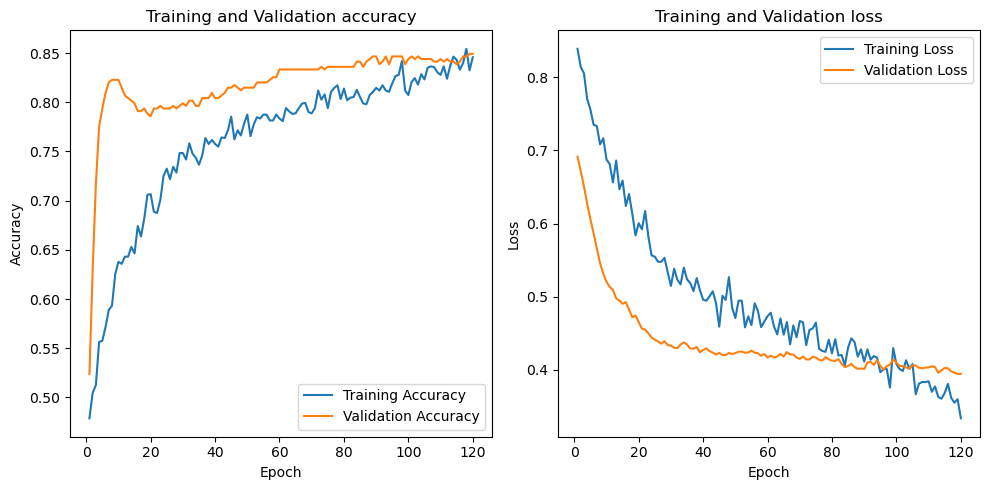

In [41]:
plotLearningCurve(r,n_epochs,'2')

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step


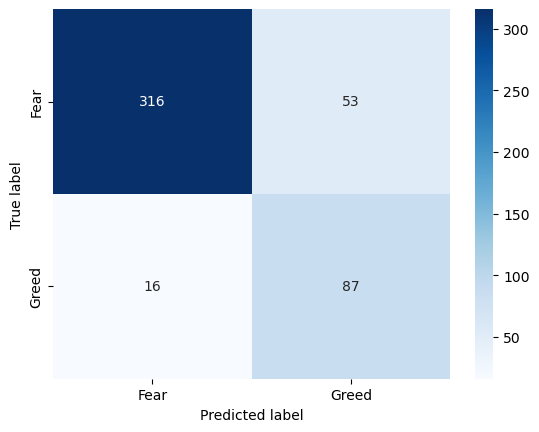

              precision    recall  f1-score   support

           0       0.95      0.86      0.90       369
           1       0.62      0.84      0.72       103

    accuracy                           0.85       472
   macro avg       0.79      0.85      0.81       472
weighted avg       0.88      0.85      0.86       472



In [42]:
#Generate predictions for the test dataset
ypred = model.predict(pad_test)
ypred = ypred>0.5
#Get the confusion matrix
cf_matrix = confusion_matrix(ytest, ypred)
class_names = ['Fear', 'Greed']
sns.heatmap(cf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.savefig('RNNmat.png')
plt.show()
print(classification_report(ytest, ypred))